In [14]:
# https://ai.plainenglish.io/audio-data-music-genre-classification-8fe58cc9444e
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments
import torchaudio
import torchaudio.transforms as T
import torch
import numpy as np
import os

In [15]:
# model_id = "ntu-spml/distilhubert"
model_path = 'distilhubert-finetuned-vowels_voice/checkpoint-420'
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_path, do_normalize=True, return_attention_mask=True
)

sampling_rate = feature_extractor.sampling_rate

In [16]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [17]:
from datasets import load_dataset, Audio

dataset = load_dataset('audiofolder', data_dir='Rebetika_vowels')
dataset_whole = load_dataset('audiofolder', data_dir='Rebetika_whole')

Resolving data files:   0%|          | 0/337 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/49 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/114 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

In [18]:
# resample audio files to desired sample rate
dataset = dataset.cast_column('audio', Audio(sampling_rate=sampling_rate))
dataset_whole = dataset_whole.cast_column('audio', Audio(sampling_rate=sampling_rate))

In [19]:
max_duration = 10.0

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [20]:
dataset_encoded = dataset.map(
    preprocess_function,
    remove_columns=['audio'],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 337
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 49
    })
})

In [21]:
dataset_encoded['train']

Dataset({
    features: ['label', 'input_values', 'attention_mask'],
    num_rows: 337
})

In [22]:
dataset_whole_encoded = dataset_whole.map(
    preprocess_function,
    remove_columns=['audio'],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_whole_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 114
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 23
    })
})

In [23]:
id2label_fn = dataset['train'].features['label'].int2str
id2label_fn(dataset['train'][-1]['label'])
# for i in range(len(dataset['test'])):
#     print(dataset['test'][i]['label'])

'Tsaousakis'

In [24]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(dataset_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

In [25]:
id2label['6']

'Tsaousakis'

In [26]:
num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_path,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

In [27]:
t = torch.FloatTensor( dataset_encoded['train'][50]['input_values'] )
tt = t.view(1, t.shape[0])
print(tt.shape)

torch.Size([1, 9383])


In [28]:
model.eval()

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPositionalConvEmbedding(

In [29]:
# run accuracy on test set
test_results = []
test_accuracy = []
for datapoint in dataset_encoded['test']:
    t = torch.FloatTensor( datapoint['input_values'] )
    c = model( t.view(1, t.shape[0]) )['logits'].argmax()
    test_results.append( c )
    test_accuracy.append( c == datapoint['label'] )
# test_results = np.array( test_arrays )
# test_prediction = model(tt)
# print(test_prediction['logits'].argmax())

In [30]:
print('test_accuracy: ', np.sum(test_accuracy)/len(test_accuracy))

test_accuracy:  0.8163265306122449


In [31]:
# run whole accuracy
# run accuracy on test set
whole_results = []
whole_accuracy = []
for train_test in ['train', 'test']:
    for datapoint in dataset_whole_encoded[train_test]:
        t = torch.FloatTensor( datapoint['input_values'] )
        c = model( t.view(1, t.shape[0]) )['logits'].argmax()
        whole_results.append( c )
        whole_accuracy.append( c == datapoint['label'] )

In [32]:
print('whole_accuracy: ', np.sum(whole_accuracy)/len(whole_accuracy))

whole_accuracy:  0.656934306569343


In [33]:
h = model.hubert( tt ).last_hidden_state
print(h.shape) # (batch_size, sequence_length, hidden_size)
p = model.projector( h )
print(p.shape)
f = p.mean(axis=1)
print(f.shape)
fp = f.detach().numpy()
print(fp.shape)

torch.Size([1, 29, 768])
torch.Size([1, 29, 256])
torch.Size([1, 256])
(1, 256)


In [34]:
def extract_hubert(d):
    h = model.hubert( d ).last_hidden_state
    p = model.projector( h )
    f = p.mean(axis=1)
    return f.detach().numpy()

In [35]:
values = []
file_names = []
ids = {}
idxs = {}
ii = 0
for train_test in ['train', 'test']:
    ids[train_test] = []
    idxs[train_test] = []
    for i, datapoint in enumerate(dataset_encoded[train_test]):
        t = torch.FloatTensor( datapoint['input_values'] )
        values.append( extract_hubert( t.view(1, t.shape[0]) ) )
        file_names.append( dataset[train_test]['audio'][i]['path'].split('/')[-1] )
        ids[train_test].append( datapoint['label'] )
        idxs[train_test].append( ii )
        ii += 1

In [36]:
print(ids)
print(file_names)

{'train': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [37]:
values_np = np.array(values).squeeze()

In [38]:
print(values_np.shape)

(386, 256)


In [39]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [54]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(values_np)

In [55]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(values_np)
print('explained ratio:', pca.explained_variance_ratio_, ' - total: ', np.sum( pca.explained_variance_ratio_ ))

explained ratio: [0.42063344 0.26611787 0.17163274]  - total:  0.858384


In [56]:
print(X_embedded.shape)
print(len(file_names))
tmp_dict = {
    'names': file_names,
    'x': X_embedded[:,0],
    'y': X_embedded[:,1]
}
print(X_PCA.shape)
tmp_dict_PCA = {
    'names': file_names,
    'x': X_PCA[:,0],
    'y': X_PCA[:,1],
    'z': X_PCA[:,2]
}

(386, 2)
386
(386, 3)


In [57]:
import pandas as pd
tmp_df = pd.DataFrame(tmp_dict)
tmp_def = tmp_df.set_index('names', inplace=True)
tmp_df_PCA = pd.DataFrame(tmp_dict_PCA)
tmp_def_PCA = tmp_df_PCA.set_index('names', inplace=True)

In [58]:
tmp_df.head()

,x,y
names,,
Bellou_a_2.mp3,-14.817413,20.026058
Bellou_a_3.mp3,-3.780164,-54.827621
Bellou_a_4.mp3,-0.915239,-53.741947
Bellou_a_5.mp3,-2.516448,-53.745823
Bellou_a_6.mp3,-3.812072,-50.352226


In [59]:
tmp_df_PCA.head()

,x,y,z
names,,,
Bellou_a_2.mp3,2.236056,-6.705590,-4.355881
Bellou_a_3.mp3,7.544067,-0.588950,-0.268951
Bellou_a_4.mp3,7.945791,-0.237960,-2.450706
Bellou_a_5.mp3,8.613728,-1.355972,-2.128227
Bellou_a_6.mp3,9.812187,0.691088,-1.125031


In [60]:
tmp_df.to_csv('features/vowels_coordinates.csv')
tmp_df_PCA.to_csv('features/vowels_PCA_coordinates.csv')

In [61]:
import matplotlib.pyplot as plt

In [62]:
labels = []
for i in ids['train']:
    labels.append( id2label[str(i)] )

[]

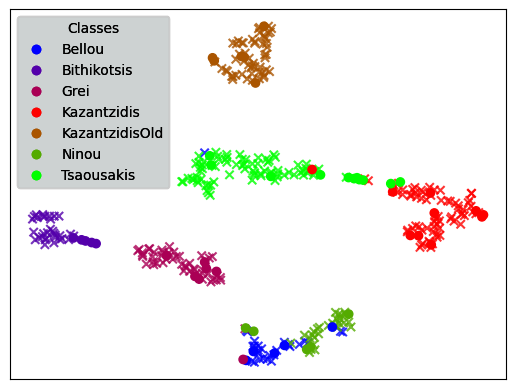

In [63]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_embedded[idxs['train'],0], X_embedded[idxs['train'],1], marker='x', c=ids['train'], cmap='brg', alpha=0.8)
scatter = ax.scatter(X_embedded[idxs['test'],0], X_embedded[idxs['test'],1], marker='o', c=ids['test'], cmap='brg')
legends = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
legends.get_frame().set_alpha(None)
legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
for i,t in enumerate(legends.get_texts()):
    t.set_text( id2label[str(i)].replace('KaitiGkrey', 'Grei'))
ax.add_artist(legends)
ax.set_xticks([])
ax.set_yticks([])

In [64]:
os.makedirs('figs', exist_ok=True)
fig.savefig('figs/tsne_vowels.png', dpi=300)

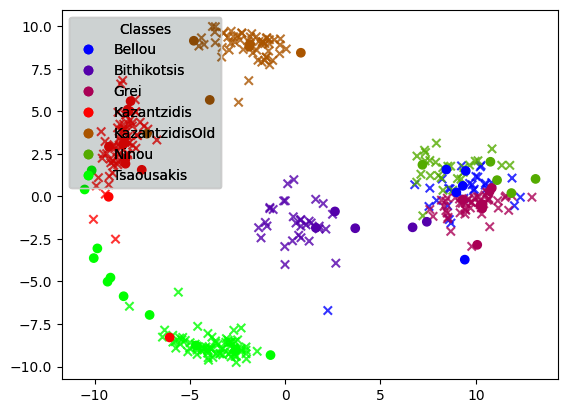

In [68]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_PCA[idxs['train'],0], X_PCA[idxs['train'],1], marker='x', c=ids['train'], cmap='brg', alpha=0.8)
scatter = ax.scatter(X_PCA[idxs['test'],0], X_PCA[idxs['test'],1], marker='o', c=ids['test'], cmap='brg')
legends = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
legends.get_frame().set_alpha(None)
legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
for i,t in enumerate(legends.get_texts()):
    t.set_text( id2label[str(i)].replace('KaitiGkrey', 'Grei') )
ax.add_artist(legends)

In [66]:
os.makedirs('figs', exist_ok=True)
fig.savefig('figs/pca_vowels.png', dpi=300)